# Packages

In [96]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [97]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [98]:
football = pd.read_csv(RAW_DIR / "football_copy.csv")

# EDA

In [99]:
def visualize_dist(col, tilt_labels:bool = False):

    counts = football[col].value_counts()

    fig, ax = plt.subplots(figsize= (10,3))
    bars = ax.bar(counts.index, counts)
    ax.bar_label(bars)
    ax.set_ylim(0, max(counts)*1.1)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {col}")
    if tilt_labels:
        ax.set_xticklabels(counts.index, rotation=45, ha='right')
    plt.show()

Looking at available columns

In [100]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_one_on_one'],
      dtype='object')

## Background info

ID column looks good. 45220 Unique values for 45220 rows. No missing values.

In [101]:
football["id"].describe()

count                                    45719
unique                                   45719
top       ba46e9d6-e828-4599-952c-39c1f7d22659
freq                                         1
Name: id, dtype: object

## Event Data

Small number of penalties and even smaller number of corner which were attempted as shots. We will remove them because there are only 13 corner shots and penalties are a different type of event altogether.

/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_11160/2812456684.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


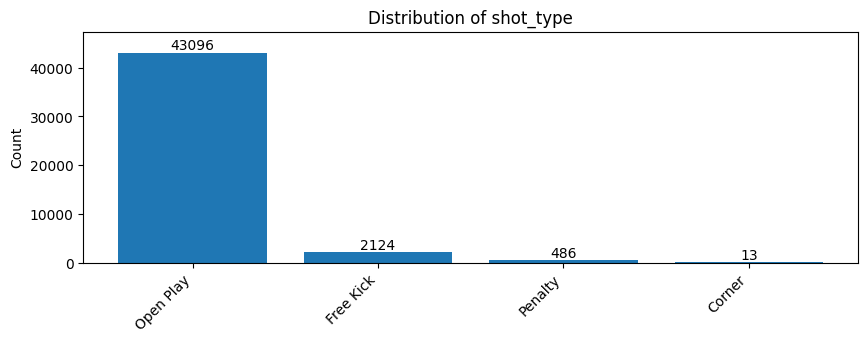

In [102]:
visualize_dist("shot_type", True)

Variety of play patterns with "from keeper", "other", and "from kick off" occuring less frequently. Number of occurences seem high enough to keep all categories for now.

/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_11160/2812456684.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


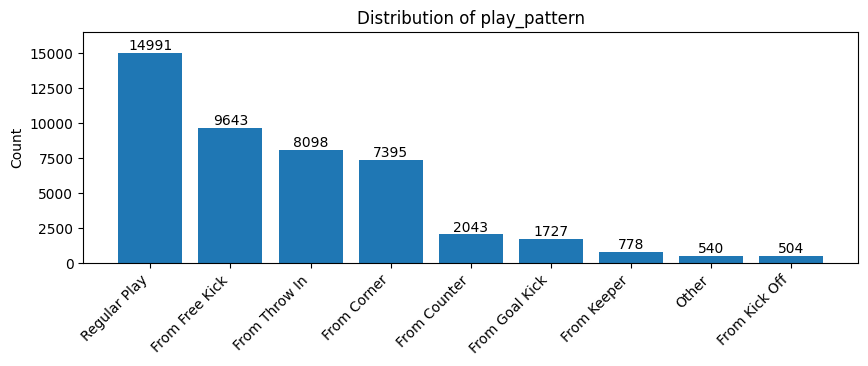

In [103]:
visualize_dist("play_pattern", True)

Will need to combine right and left foot into one variable since we do not know, if a players left or right foot is stronger and this might impact the model later on.

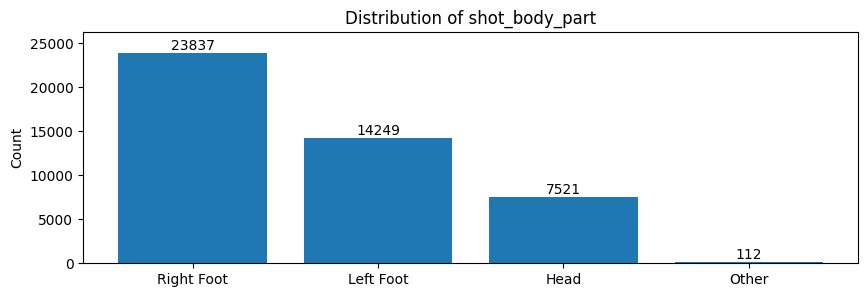

In [104]:
visualize_dist("shot_body_part")

Will need to transform shot outcome into binary variable for modeling. 1 for goal, 0 for no goal.

/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_11160/2812456684.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


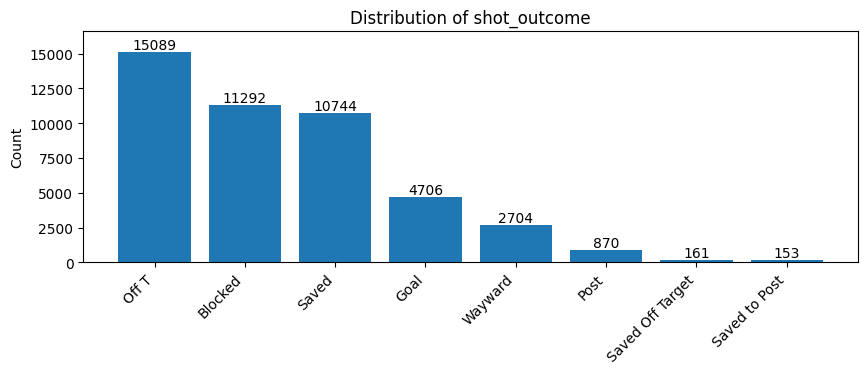

In [105]:
visualize_dist("shot_outcome", True)

Shot technique provides interesting details how shot was taken. There are 3 categories (overhead kick, backheel and diving header) which are less frequent. We still keep them as they might provide useful information for the model since they are harder to execute.

/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_11160/2812456684.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


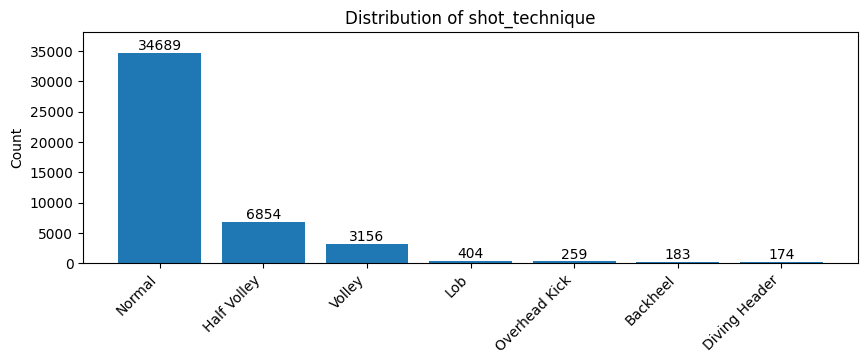

In [106]:
visualize_dist("shot_technique", True)

## Other

There appear to be missing values for:
- under pressure
- shot deflected
- shot open goal
- shot freeze frame
- shot first time
- shot technique
- shot one on one

Upon inspection of the data documentation it appears like this is the way it is being recorded in statsbombs systems. They only capture True values and leave the rest blank (NaN). Therefore we will impute missing values with False for these boolean columns.

In [108]:
football[['play_pattern', 'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_one_on_one']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45719 entries, 0 to 45718
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   play_pattern       45719 non-null  object 
 1   type               45719 non-null  object 
 2   under_pressure     12290 non-null  object 
 3   shot_deflected     628 non-null    object 
 4   shot_open_goal     484 non-null    object 
 5   shot_type          45719 non-null  object 
 6   shot_statsbomb_xg  45719 non-null  float64
 7   shot_freeze_frame  45285 non-null  object 
 8   location           45719 non-null  object 
 9   shot_outcome       45719 non-null  object 
 10  shot_body_part     45719 non-null  object 
 11  shot_first_time    14402 non-null  object 
 12  shot_technique     45719 non-null  object 
 13  shot_one_on_one    2332 non-null   object 
dtypes: float64(1), object(13)
memory usage: 4.9+ MB


There is no shot_freeze_frame for penalty kicks. This is another reason why we should remove penalty kicks from the dataset.

In [109]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    434
Name: count, dtype: int64